In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sbrn
import numpy as np
import re
import datetime

%matplotlib inline

In [2]:
dat = pd.read_csv('../data/water_pump/training.csv', header=0)

In [3]:
labels = pd.read_csv('../data/water_pump/training_labels.csv', header=0)
#join labels to dat on "id" (left outer)

dat=dat.merge(labels, how='left', left_on='id', right_on='id',copy=False)

In [4]:
pd.set_option('display.max_columns', 50)
dat.sample(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
34055,32962,0.0,2011-07-22,World Vision,0,DWE,31.768268,-1.349268,Kibimbili,0,Lake Victoria,Buliampulu,Kagera,18,2,Bukoba Rural,Kabaragaine,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,improved spring,improved spring,functional
47411,53843,250.0,2013-02-09,Imf,1282,Government,29.889779,-4.491243,Kwa Yusufu,0,Lake Tanganyika,Kifulifuli,Kigoma,16,2,Kasulu,Janda,300,True,GeoData Consultants Ltd,Water authority,Nyasovu,True,2007,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
3192,64517,50.0,2011-03-23,Private Individual,14,Da,38.891389,-6.563976,Msikitini,0,Wami / Ruvu,Buma Magharibi,Pwani,6,1,Bagamoyo,Kiromo,200,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,2010,ksb,submersible,submersible,private operator,commercial,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
42192,16121,0.0,2013-02-18,Kalitasi,1470,Kalitasi,37.984706,-4.224608,Zahanati,0,Pangani,Mwala,Kilimanjaro,3,3,Same,Vuje,120,True,GeoData Consultants Ltd,VWC,Ntenga Water Supply,True,2002,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
42950,14403,0.0,2012-10-31,Tlc,0,TLC,32.059683,-5.053477,Ezekiel Elias,0,Lake Tanganyika,Urambo Magharibi Kaskazini,Tabora,14,4,Urambo,Urambo,0,True,GeoData Consultants Ltd,Private operator,NaN,True,0,other,other,other,private operator,commercial,never pay,never pay,milky,milky,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


In [5]:
dat.shape

(59400, 41)

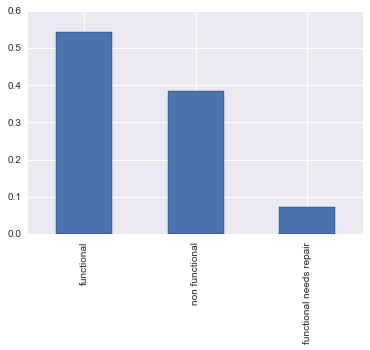

In [7]:
# OUTCOME VARIABLE CLASS PROPORTIONS

dat.status_group.value_counts(normalize=True).plot(kind='bar')
#class "functional needs repair" is severely imbalanced (<10% of dataset)

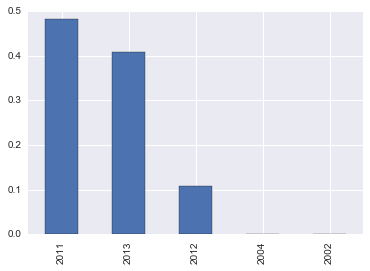

In [6]:
# TIME ANALYSIS
#not a time series, readings are sporadic, there are gaps in years
dat['date_recorded']=pd.to_datetime(dat.date_recorded)
dat['year']=dat.date_recorded.dt.year

#2004 and 2002 datapoints; <1% of the dataset combined
dat.year.value_counts(normalize=True).plot(kind='bar')

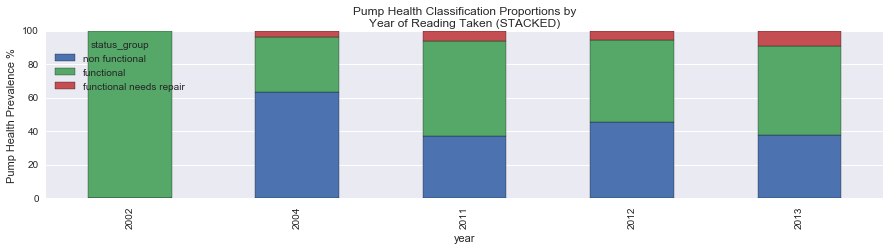

In [129]:
# Checking out outcome variable proportion by year reading taken:

temp=pd.crosstab(dat.status_group, dat.year).apply(lambda col: ((col/col.sum()).round(3))*100, axis=0)
temp=temp.reindex(['non functional','functional','functional needs repair'])
temp.transpose().plot(kind='bar',legend='status_group',stacked=True,figsize=(15,3), 
                      title='Pump Health Classification Proportions by\nYear of Reading Taken (STACKED)')
plt.ylabel( 'Pump Health Prevalence %')

#we see that 2002 is misleading in its classification distribution (Only 1 data point in 2002). Suggest removing that.

In [104]:
# Checking out Pump health proportion by construction years:
temp1=pd.crosstab(dat.status_group, dat.construction_year).apply(lambda col: ((col/col.sum()).round(3))*100, axis=0)
temp1=temp1.reindex(['non functional','functional','functional needs repair'])
temp1

construction_year,0,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
status_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
non functional,40.4,70.6,76.2,73.3,56.5,80.0,36.8,64.7,45.5,66.2,69.5,72.3,39.3,65.3,65.8,59.6,57.7,66.9,64.4,49.6,72.4,60.8,59.7,61.0,57.4,...,43.4,45.0,51.2,37.2,47.5,42.7,34.1,46.5,44.4,34.9,24.3,32.3,31.9,30.2,30.1,31.1,34.0,30.8,24.6,24.8,24.5,20.1,18.7,28.3,41.5
functional,51.0,23.5,9.5,23.3,36.5,17.5,57.9,35.3,35.2,28.6,25.4,24.1,56.6,25.1,29.9,34.6,33.0,20.5,30.7,41.1,21.4,31.8,35.7,31.7,38.3,...,52.2,48.8,43.5,56.4,46.9,51.5,58.5,47.6,45.2,56.1,70.9,61.2,61.3,64.4,64.4,62.7,57.2,60.0,68.1,70.4,70.0,76.5,75.1,67.0,58.0
functional needs repair,8.6,5.9,14.3,3.3,7.1,2.5,5.3,0.0,19.3,5.2,5.1,3.6,4.1,9.6,4.3,5.8,9.4,12.6,5.0,9.4,6.2,7.4,4.6,7.3,4.3,...,4.4,6.2,5.2,6.4,5.6,5.8,7.4,5.9,10.4,9.0,4.8,6.5,6.9,5.4,5.5,6.2,8.8,9.2,7.3,4.9,5.4,3.4,6.2,4.7,0.6


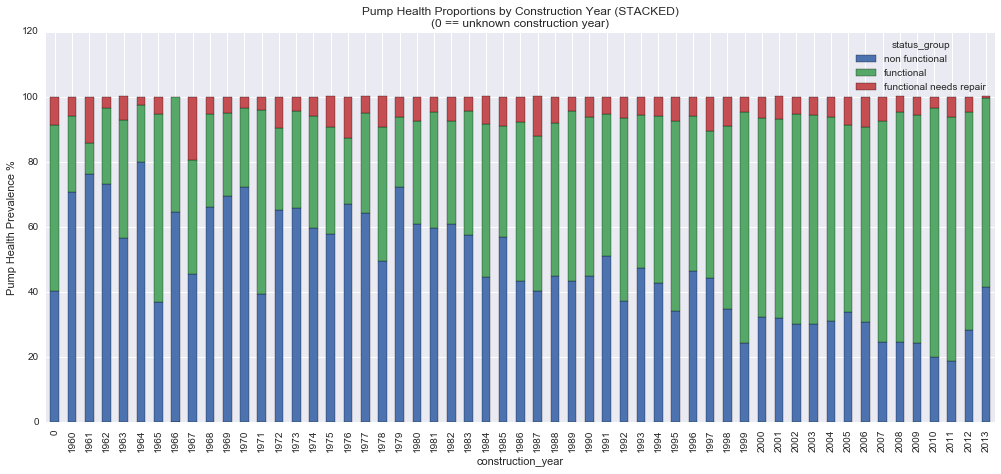

In [106]:
fig, ax = plt.subplots(1,1,figsize=(17,7))
temp1.transpose().plot(kind='bar', legend='status_group', stacked=True, ax=ax)
#temp1.iloc[1,:].plot(kind='bar', color='green', ax=ax, legend='status_group', bottom=temp1.iloc[0,:])
#temp1.iloc[2,:].plot(kind='bar', color='red', ax=ax, legend='status_group')
ax.set_ylabel('Pump Health Prevalence %')
ax.set_title('Pump Health Proportions by Construction Year (STACKED)\n(0 == unknown construction year)')

#not surprisingly, older pumps breakdown a lot more than the newer ones. 
#There's also the '0' group that's missing construction year. 
#pumps needing repair are more or less evenly spread out by age of pump
#all this suggests either that newer pumps breakdown less, or that maintenance is better lately, or both

In [115]:
#what % of "construction years" are missing?
round((len(dat[dat.construction_year==0])/float(len(dat)))*100, 2)

34.86

In [9]:
# NUMERIC VARIABLES ANALYSIS

dat.describe(include=['int64','float64','float32']) 
#coded categoricals also show up

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,2011.921667
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.958758
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,2011.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2013.000000


In [153]:
# Which categoricals are visualization friendly (taking a quick look at unique values for every column)
dat.apply(lambda cols: len(cols.unique()), axis=0)

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1898
gps_height                2428
installer                 2146
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19288
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               3
recorded_by                  1
scheme_management           13
scheme_name               2697
permit                       3
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

status_group
functional                 Axes(0.547727,0.125;0.352273x0.227941)
functional needs repair    Axes(0.547727,0.125;0.352273x0.227941)
non functional             Axes(0.547727,0.125;0.352273x0.227941)
Name: population, dtype: object

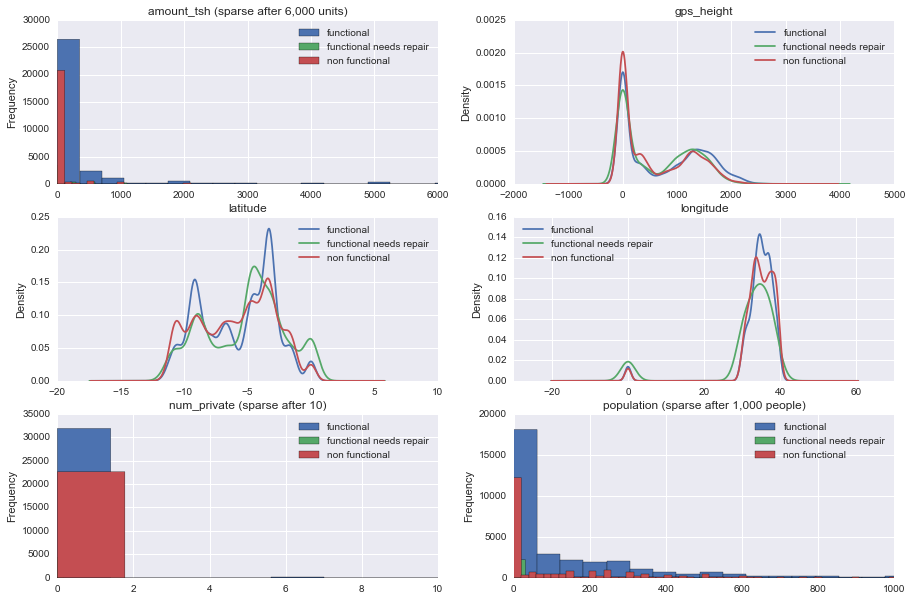

In [150]:
# TAKING A LOOK AT DISTRIBUTIONS OF CONTINUOUS VARIABLES, SEGMENTED BY STATUS_GROUP (pump health)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(15,10))
dat.groupby(dat.status_group)['amount_tsh'].plot.hist(ax=ax1,legend=True, title='amount_tsh (sparse after 6,000 units)', bins=1000, xlim=(0,6000)) #total static head (amount water available to waterpoint)
dat.groupby(dat.status_group)['gps_height'].plot(kind='kde',ax=ax2,legend=True,title='gps_height') #Altitude of the well
dat.groupby(dat.status_group)['latitude'].plot(kind='kde',ax=ax3,legend=True, title='latitude')
dat.groupby(dat.status_group)['longitude'].plot(kind='kde',ax=ax4,legend=True, title='longitude')
dat.groupby(dat.status_group)['num_private'].plot.hist(ax=ax5,legend=True, title='num_private (sparse after 10)', bins=1000, xlim=(0,10)) #no desc
dat.groupby(dat.status_group)['population'].plot.hist(ax=ax6,legend=True, title='population (sparse after 1,000 people)',bins=500, xlim=(0,1000)) #pop around the well

In [182]:
#% of missing num_private values
round(len(dat[dat.num_private==0])/float(len(dat)),3)*100

98.7

In [186]:
#% of missing population values
round(len(dat[dat.population==0])/float(len(dat)),3)*100

36.0

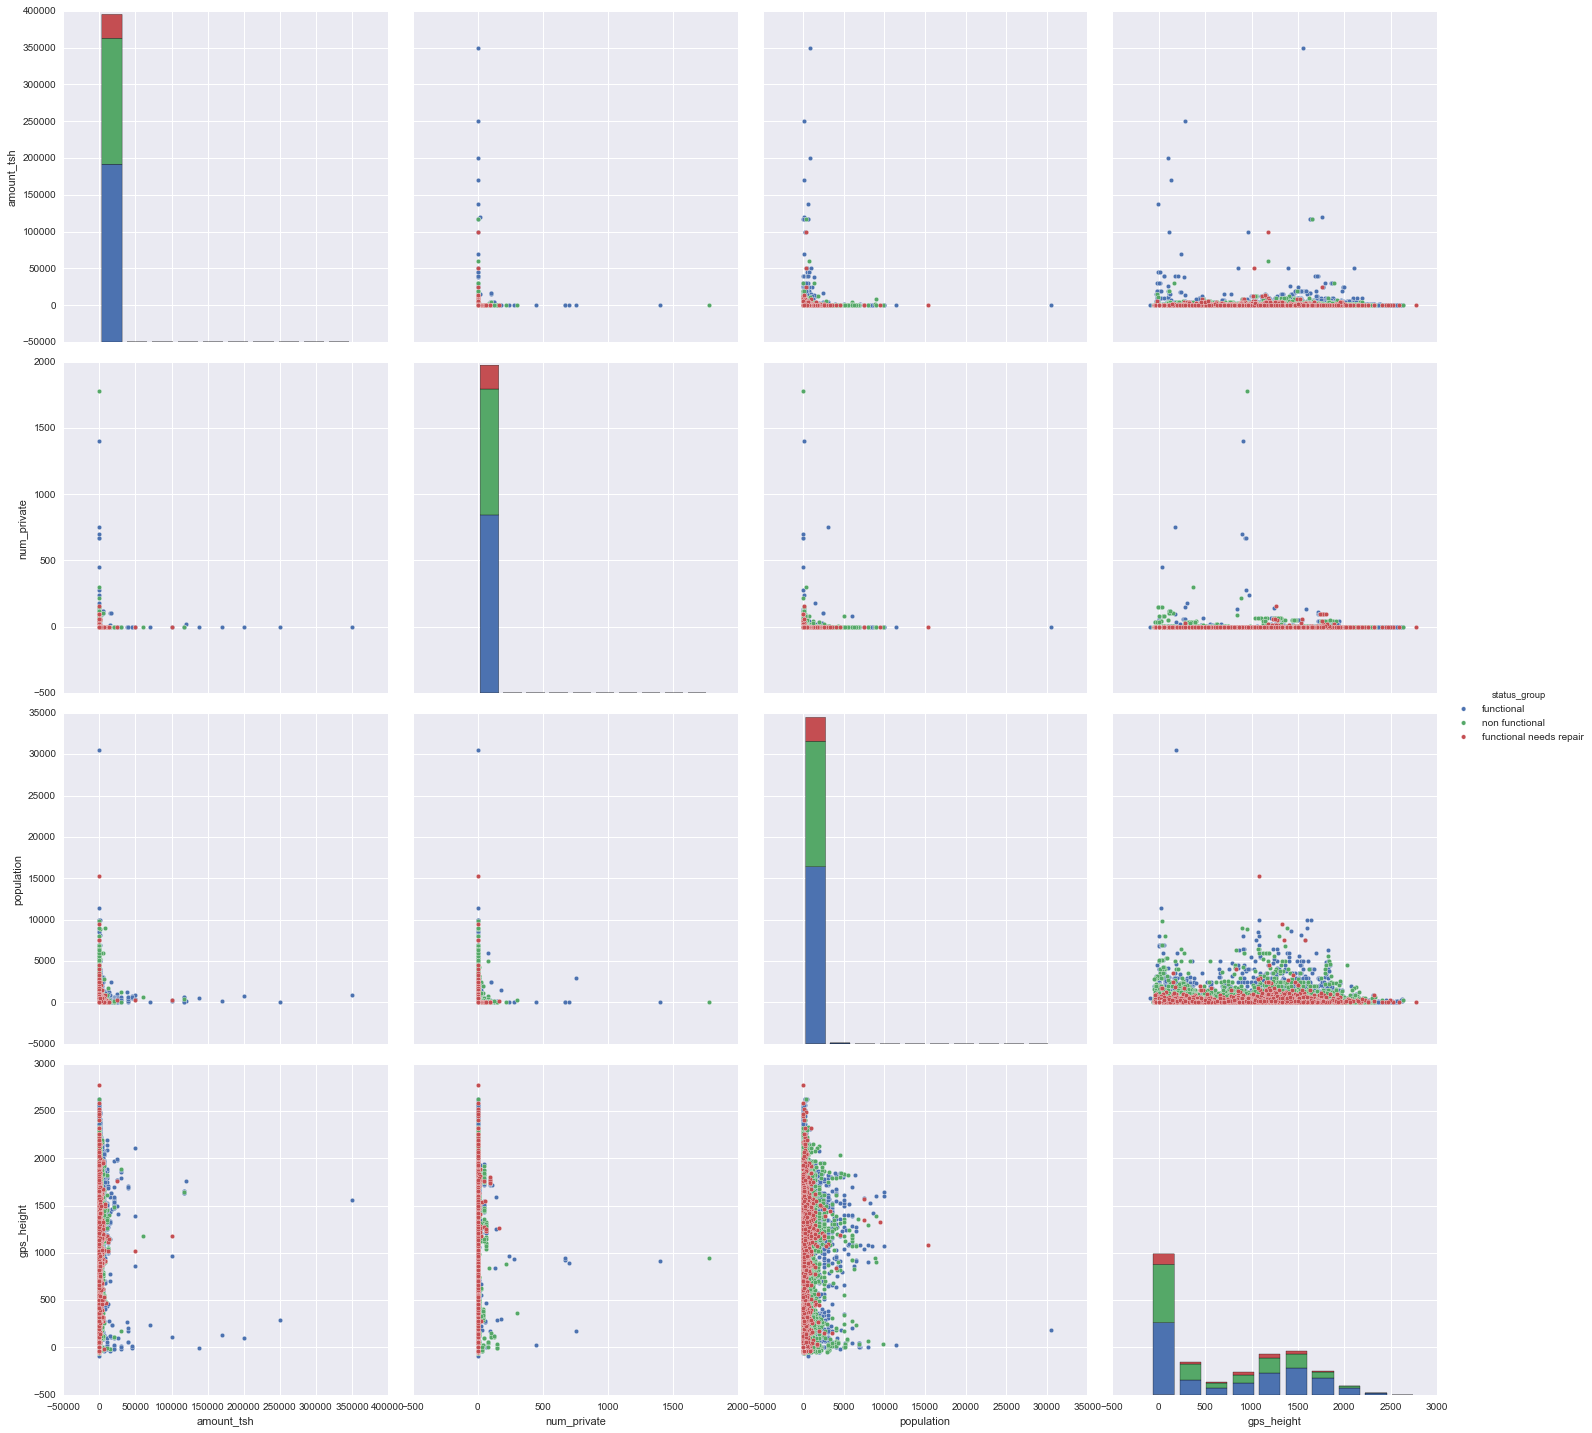

In [195]:
#closer look at data points
sbrn.pairplot(dat.loc[:,['amount_tsh','num_private','population','gps_height','status_group']], 
              hue="status_group",
              size=5)


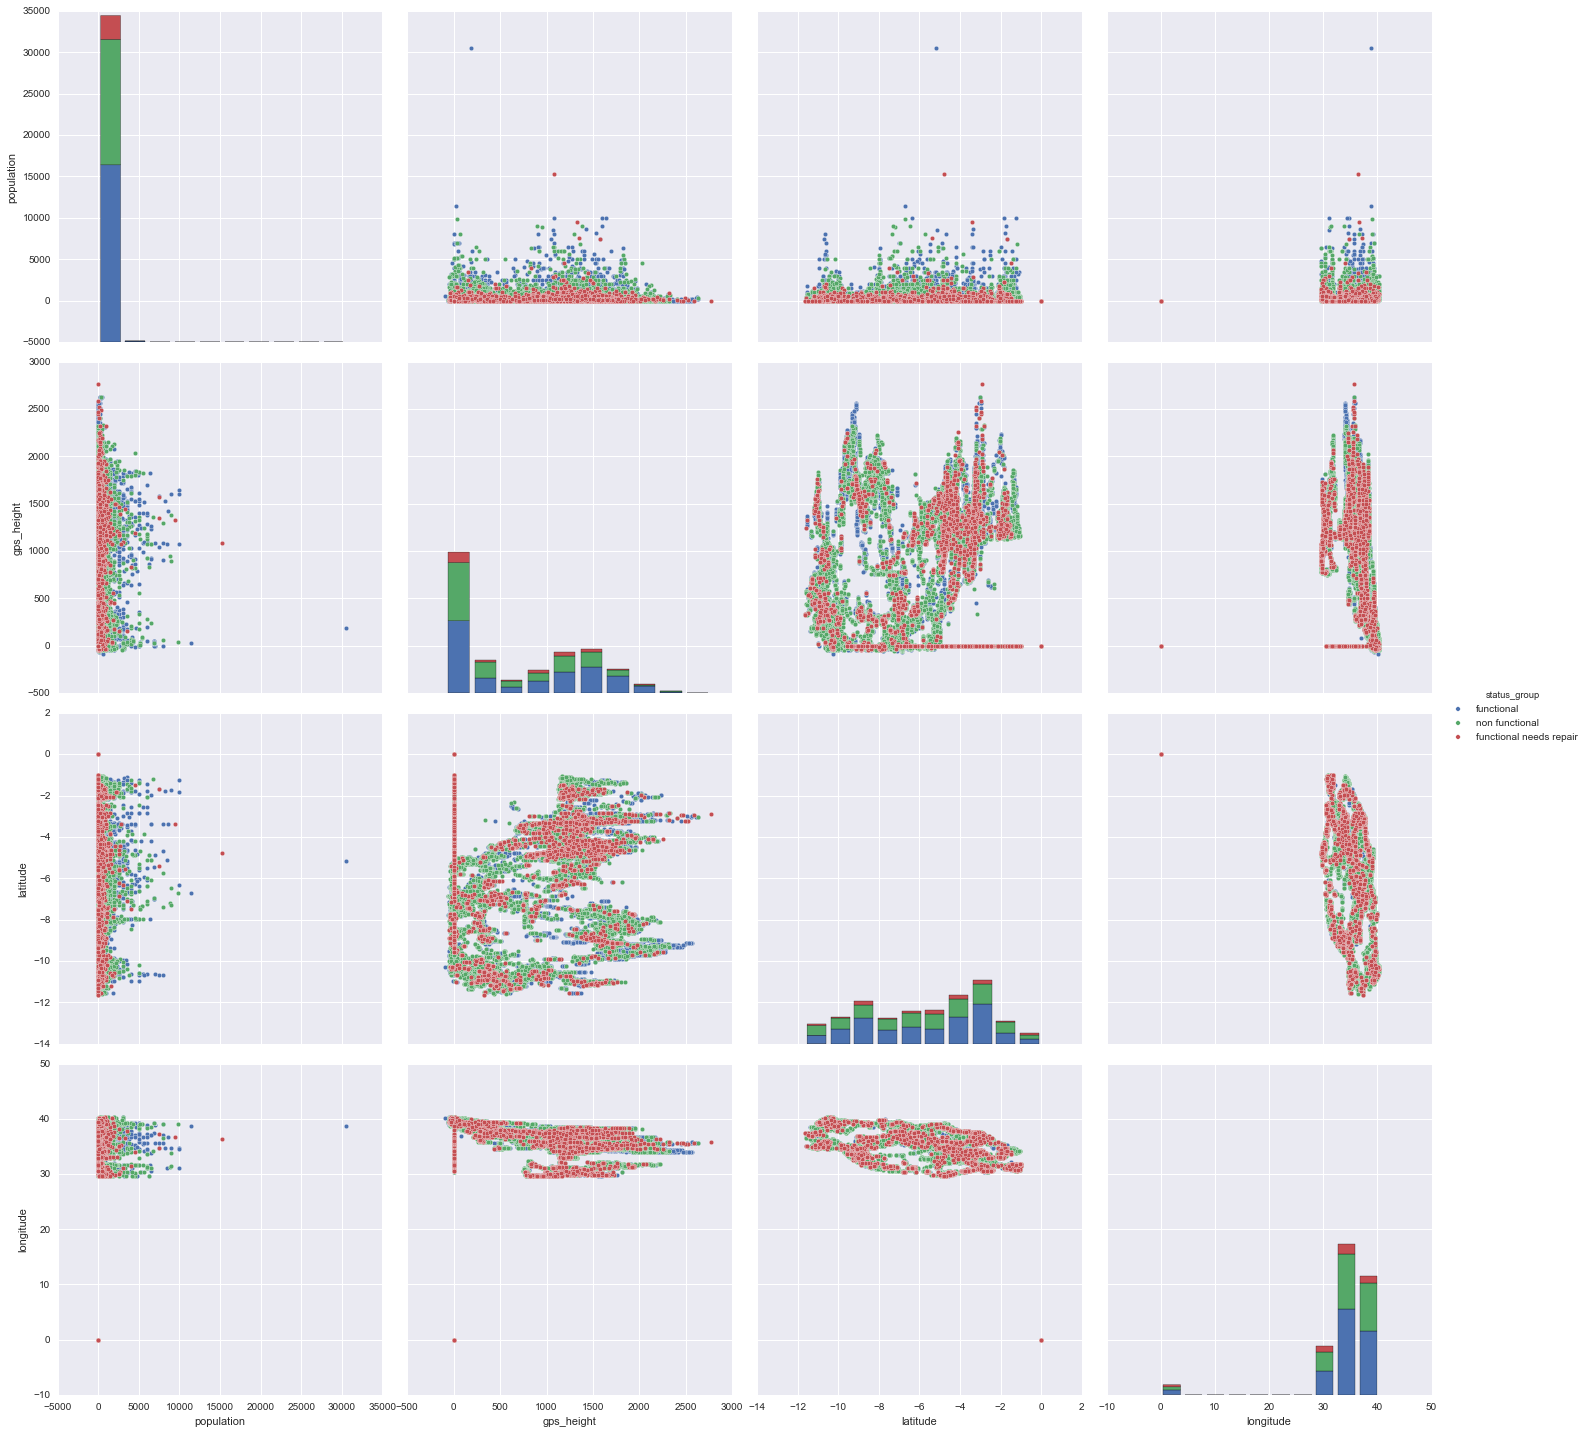

In [194]:
#too many missing values in num_private and amount_tsh, hard to infer anything. Remove and insert lat, long for some location analysis
sbrn.pairplot(dat.loc[:,['population','gps_height','status_group','latitude','longitude']], 
              hue="status_group",
              size=5)

In [ ]:
#funder
dat['funder']=dat['funder'].astype('category',copy=False)

In [ ]:
dat.funder.value_counts(normalize=True).head(20).plot(kind='bar', figsize=(15,5))
plt.title('Frequency of "Funder" Categories in Dataset: Top 20')
#Top 20-ish funders get close to making up about 50% of the dataset

In [ ]:
dat.funder.sample(5)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sbrn.distplot(dat.gps_height, kde=True, rug=False)
#sbrn.boxplot(dat.gps_height, ax=ax2)



In [ ]:
sbrn.pairplot(dat, hue="status_group",size=5, diag_kind='kde')